In [2]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [3]:
# python standard library imports
from typing import Self, Any
from pathlib import Path

In [4]:
from keras.utils import image_dataset_from_directory

In [5]:
# augmentation operations
from keras.layers import Rescaling, RandAugment

In [6]:
from matplotlib.image import imread

In [7]:
from src.utils import show_image

In [8]:
# model building
from keras import Model
from keras.applications import VGG16
from keras.layers import Flatten, Dense

In [9]:
# model training imports
from keras.optimizers import SGD
from keras.losses import CategoricalCrossentropy
from keras.metrics import CategoricalAccuracy, AUC, F1Score
from keras.callbacks import ModelCheckpoint, CSVLogger, LearningRateScheduler

In [10]:
from src.utils import exp_decay_lr_scheduler

In [11]:
# load data pointer from directory
# sample from fitzpatrick_17k (last year project), 114 classes

In [12]:
root_dir_path = Path(".")
# data_dir_path = root_dir_path / "data"

# train_dir_path = data_dir_path / "train"
# val_dir_path = data_dir_path / "val"
# test_dir_path = data_dir_path / "test"

train_dir_path = "C:\\DeepLearningDatabase\\data\\train"
val_dir_path = "C:\\DeepLearningDatabase\\data\\val"
test_dir_path = "C:\\DeepLearningDatabase\\data\\test"

<div class="alert alert-block alert-" style="color:white; background-color: rgb(0, 90, 100); border: 0px; -moz-border-radius: 10px; -webkit-border-radius: 10px;">

## **CNN for Image Classification**

</div>

- É a mesma estrutura p/ o projeto! **Mas ele não quer que copiemos tudo tudo!**

In [13]:
n_classes = 114
batch_size = 64
input_shape = (224, 224, 3)
image_size = (224, 224)
value_range = (0.0, 1.0)

In [14]:
train_ds = image_dataset_from_directory(
    train_dir_path,
    label_mode="categorical",
    batch_size=batch_size,
    image_size=image_size,
    interpolation="bilinear",
    verbose=False
)

In [15]:
val_ds = image_dataset_from_directory(
    val_dir_path,
    label_mode="categorical",
    batch_size=batch_size,
    image_size=image_size,
    interpolation="bilinear",
    shuffle=False,
    verbose=False
)

In [16]:
test_ds = image_dataset_from_directory(
    test_dir_path,
    label_mode="categorical",
    batch_size=batch_size,
    image_size=image_size,
    interpolation="bilinear",
    shuffle=False,
    verbose=False
)

In [17]:
# pre-trained model (transfer learning), with some augmentation

In [18]:
class AugmentedVGG16(Model):
    """
    Pre-trained VG16 + RandAugment
    """

    def __init__(self: Self) -> None:
        """
        Initialization
        """

        super().__init__()

        self.n_classes = n_classes
        self.rescale_layer = Rescaling(scale=1 / 255.0)
        self.augmentation_layer = RandAugment(value_range=value_range)
        self.pre_trained_architecture = VGG16(include_top=False, classes=32)   # 32 classes (pq? TÁ MAL!)
        self.flatten_layer = Flatten()
        self.dense_layer = Dense(self.n_classes, activation="softmax")

    def call(self: Self, inputs: Any) -> Any:
        """
        Forward call
        """

        x = self.rescale_layer(inputs)
        x = self.augmentation_layer(x)
        x = self.pre_trained_architecture(x)
        x = self.flatten_layer(x)

        return self.dense_layer(x)

In [20]:
from keras import Input

model = AugmentedVGG16()
input = Input((224, 224, 3))
_ = model.call(input)
model.summary()

Model: "augmented_vgg16_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rand_augment_1 (RandAugment)    │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 114)            │     2,860,146 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,574,834 (67.04 MB)

 Trainable params: 17,574,834 (67.04 MB)

 Non-trainable params: 0 (0.00 B)

- (7,7, 512) -> [_, _, _, ]

$.\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;$ _ = 7x7x512 = 25088

- **Dense(4096)** -> 4096 * 25088 = 102760448

In [ ]:
# how RandAugment affects the image inputs?

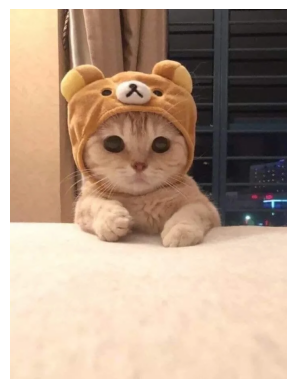

In [26]:
cute_cat_file_path = root_dir_path / "cute_cat.png"
cute_cat_example = imread(cute_cat_file_path)
show_image(cute_cat_example)

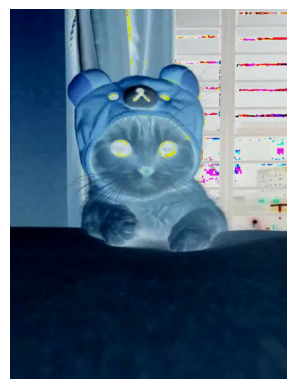

In [27]:
augmentation_layer = RandAugment(factor=0.1, value_range=value_range)
augmented_train_example = augmentation_layer(cute_cat_example).numpy()
show_image(augmented_train_example)

In [28]:
epochs = 4
model = AugmentedVGG16()
optimizer = SGD(learning_rate=0.01, name="optimizer")
loss = CategoricalCrossentropy(name="loss")

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [29]:
# metrics
categorical_accuracy = CategoricalAccuracy(name="accuracy")
auc = AUC(name="auc")
f1_score = F1Score(average="macro", name="f1_score")
metrics = [categorical_accuracy, auc, f1_score]

In [30]:
# callbacks
root_dir_path = Path(".")
checkpoint_file_path = root_dir_path / "checkpoint.keras"
metrics_file_path = root_dir_path / "metrics.csv"

checkpoint_callback = ModelCheckpoint(
    checkpoint_file_path,
    monitor="val_loss",
    verbose=0
)
metrics_callback = CSVLogger(metrics_file_path)
lr_scheduler_callback = LearningRateScheduler(exp_decay_lr_scheduler)

callbacks = [
    checkpoint_callback,
    metrics_callback,
    lr_scheduler_callback
]

In [31]:
model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

In [32]:
# train the model, call to the method is somewhat diferent
_ = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=callbacks,
    verbose=2
)

Epoch 1/4
8/8 - 126s - 16s/step - accuracy: 0.0022 - auc: 0.4504 - f1_score: 0.0035 - loss: 5.0164 - val_accuracy: 0.0088 - val_auc: 0.5102 - val_f1_score: 1.5664e-04 - val_loss: 4.7550 - learning_rate: 0.0095
Epoch 2/4
8/8 - 128s - 16s/step - accuracy: 0.0110 - auc: 0.4978 - f1_score: 0.0027 - loss: 4.7554 - val_accuracy: 0.0263 - val_auc: 0.4989 - val_f1_score: 0.0027 - val_loss: 4.7361 - learning_rate: 0.0090
Epoch 3/4
8/8 - 126s - 16s/step - accuracy: 0.0088 - auc: 0.5008 - f1_score: 0.0029 - loss: 4.7352 - val_accuracy: 0.0088 - val_auc: 0.5017 - val_f1_score: 2.0400e-04 - val_loss: 4.7370 - learning_rate: 0.0086
Epoch 4/4
8/8 - 122s - 15s/step - accuracy: 0.0088 - auc: 0.5024 - f1_score: 0.0027 - loss: 4.7344 - val_accuracy: 0.0088 - val_auc: 0.5029 - val_f1_score: 0.0058 - val_loss: 4.7377 - learning_rate: 0.0081


In [33]:
# evaluate on the test ds
model.evaluate(
    test_ds,
    return_dict=True,
    verbose=0
)

{'accuracy': 0.017543859779834747,
 'auc': 0.5046964883804321,
 'f1_score': 0.012327802367508411,
 'loss': 4.733144283294678}

---